In [1]:
# Cell 1: Setup and Imports
# Cell 1: Setup and Imports (CPU config MUST be first!)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# CPU optimization - MUST be done before importing tensorflow
import tensorflow as tf

# Set CPU limits IMMEDIATELY after importing TensorFlow
tf.config.threading.set_inter_op_parallelism_threads(9)   # 80% of 12 cores
tf.config.threading.set_intra_op_parallelism_threads(12)  # 80% of 16 threads

# Now import other TensorFlow modules
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Set seeds for reproducibility
tf.random.set_seed(42)
print("✅ TensorFlow version:", tf.__version__)
print(f"✅ CPU cores allocated: 9/12 (80%)")
print(f"✅ CPU threads allocated: 12/16 (80%)")


✅ TensorFlow version: 2.20.0
✅ CPU cores allocated: 9/12 (80%)
✅ CPU threads allocated: 12/16 (80%)


In [7]:
# Cell 2: Configuration (CPU config removed)
IMAGE_SIZE = (128, 128)  # Reduced from 150x150
BATCH_SIZE = 16         # Reduced from 32
EPOCHS = 12            # Reduced from 10
MODEL_PATH = 'models/xray_cnn_model.h5'

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('sample_images', exist_ok=True)

print("✅ Lightweight configuration loaded")



✅ Lightweight configuration loaded


In [8]:
train_dir = 'sample_images/chest_xray/train'
val_dir = 'sample_images/chest_xray/val'
test_dir = 'sample_images/chest_xray/test'

# Lighter data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,        # Reduced from 20
    width_shift_range=0.15,   # Reduced from 0.2
    height_shift_range=0.15,  # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples: 5216
Validation samples: 16
Test samples: 624


In [9]:
# Cell 4: Model Architecture
def create_optimized_cnn_model():
    model = keras.Sequential([
        # Streamlined architecture - removed one conv block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),  # Reduced from 512
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile model
model = create_optimized_cnn_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0015),  # Slightly higher LR
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()





Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 5: Training
callbacks = [
    keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),  # Reduced patience
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
    keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True)
]

# Train with simplified parameters
print("🚀 Starting optimized training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
    # Removed: workers=4 and use_multiprocessing=False (deprecated)
)

# Save training history
with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Training completed with resource optimization")





🚀 Starting optimized training...
Epoch 1/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7536 - loss: 0.5459 - precision: 0.7766 - recall: 0.9457

326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 268ms/step - accuracy: 0.7949 - loss: 0.4429 - precision: 0.8190 - recall: 0.9293 - val_accuracy: 0.6250 - val_loss: 1.0424 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 0.0015
Epoch 2/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8819 - loss: 0.2691 - precision: 0.9192 - recall: 0.9231

326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 141ms/step - accuracy: 0.8907 - loss: 0.2513 - precision: 0.9262 - recall: 0.9267 - val_accuracy: 0.7500 - val_loss: 0.7569 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0015
Epoch 3/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8973 - loss: 0.2385 - precision: 0.9349 - recall: 0.9253

326/326 ━━━━━━━━━━━━━━━━━━━━ 45s 139ms/step - accuracy: 0.9043 - loss: 0.2283 - precision: 0.9400 - recall: 0.9306 - val_accuracy: 0.8125 - val_loss: 0.4372 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 0.0015
Epoch 4/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 45s 138ms/step - accuracy: 0.9164 - loss: 0.1991 - precision: 0.9451 - recall: 0.9422 - val_accuracy: 0.6875 - val_loss: 1.0341 - val_precision: 0.6154 - val_recall: 1.0000 - learning_rate: 0.0015
Epoch 5/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 45s 137ms/step - accuracy: 0.9245 - loss: 0.1912 - precision: 0.9520 - recall: 0.9461 - val_accuracy: 0.6250 - val_loss: 1.1256 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 0.0015
✅ Training completed with resource optimization


In [11]:
# Cell 6: Evaluation and Visualization
# Evaluation
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n=== Test Results ===")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Save evaluation metrics
metrics = {
    'accuracy': float(test_accuracy),
    'precision': float(test_precision),
    'recall': float(test_recall),
    'f1_score': float(f1_score)
}

with open('models/evaluation_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)



39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.8478 - loss: 0.3461 - precision: 0.8406 - recall: 0.9333

=== Test Results ===
Accuracy: 0.8478
Precision: 0.8406
Recall: 0.9333
F1-Score: 0.8846


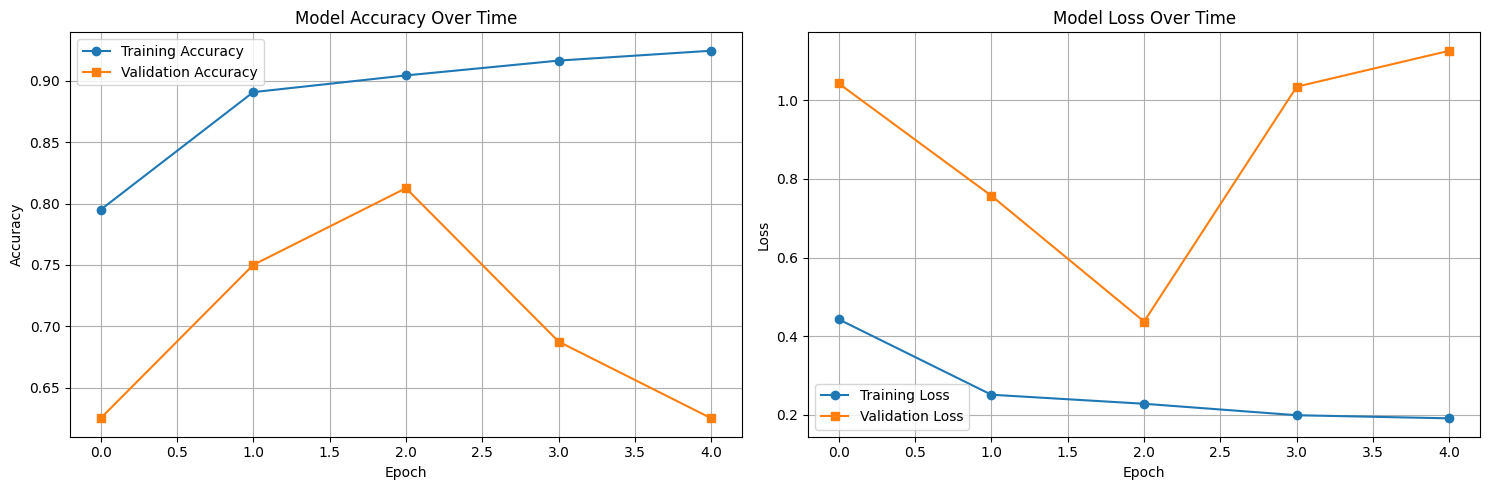

In [12]:
# Cell 7: Training History Visualization
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('Model Accuracy Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Model Loss Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)



39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


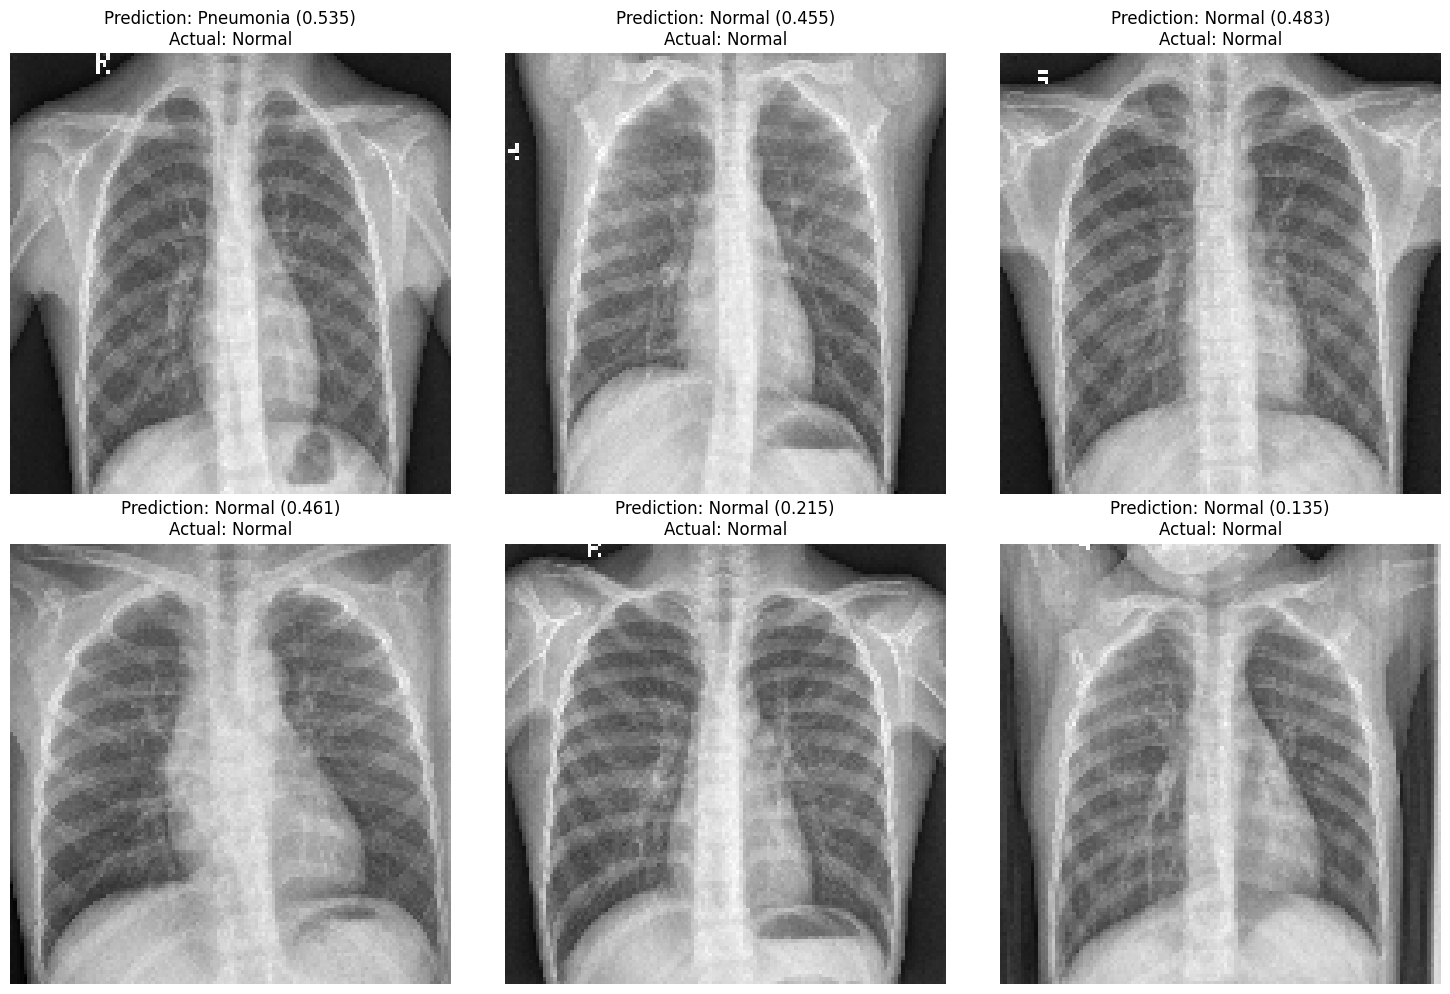

In [13]:
# Cell 8: Sample Predictions
def save_sample_predictions(model, test_generator, num_samples=6):
    predictions = model.predict(test_generator)
    
    # Get sample images and their true labels
    test_generator.reset()
    sample_batch = next(test_generator)
    images, true_labels = sample_batch
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i])
        
        pred_prob = predictions[i][0]
        pred_class = "Pneumonia" if pred_prob > 0.5 else "Normal"
        true_class = "Pneumonia" if true_labels[i] == 1 else "Normal"
        
        axes[i].set_title(f"Prediction: {pred_class} ({pred_prob:.3f})\nActual: {true_class}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('models/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

save_sample_predictions(model, test_generator)



In [14]:
# Cell 9: Model Architecture Diagram
keras.utils.plot_model(
    model, 
    to_file='models/model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    dpi=300
)

print("✅ Model training completed!")
print("✅ All artifacts saved in 'models/' directory")
print("✅ Ready for Streamlit deployment!")

You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Model training completed!
✅ All artifacts saved in 'models/' directory
✅ Ready for Streamlit deployment!


In [15]:
# Load and inspect your saved model
loaded_model = keras.models.load_model('models/xray_cnn_model.h5')
loaded_model.summary()

# Check the exact input shape it expects
print("Expected input shape:", loaded_model.input_shape)
print("First layer:", loaded_model.layers[0])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,291 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Expected input shape: (None, 128, 128, 3)
First layer: <Conv2D name=conv2d_3, built=True>
